## FedAVG
- dataset: 
    - MNIST/ CIFAR10
    - stock?
    
<img src="slide_image/FedAvg_MNIST.png" width=640  />


## Importing

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, RNN
import numpy as np

## Custom func.
CNN and RNN model

In [3]:
def simplernn(name):
    import tensorflow as tf
    from tensorflow.python.keras.models import Sequential, Model
    from tensorflow.python.keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN, RNN

    inputs = Input(shape=(28,28), name='input')
    y = SimpleRNN(units=128, activation='tanh', return_sequences=True, name='r1')(inputs)
    y = Dropout(rate=0.2, name='dr1')(y)
    y = SimpleRNN(units=128, activation='relu', return_sequences=False, name='r2')(y)
    y = Dropout(rate=0.1, name='dr2')(y)
    y = Dense(units=32, activation='relu', name='d1')(y)
#     y = Dropout(rate=0.2, name='dr3')(y)
    y = Dense(units=10, activation='softmax', name='d2')(y)
    
    model = Model(inputs=inputs, outputs=y, name=name)
    return model

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     BatchNormalization, Flatten,
                                     Conv2D, MaxPooling2D)

def simplecnn(name):
    # 選擇 Keras 的 API 寫法
    inputs = Input(shape=(28,28,1))

    # 第一層
    # 建立卷積層，設定32個3*3的filters
    # 設定ReLU為激活函數。
    x = Conv2D(32, (3, 3), activation='relu')(inputs)

    # 第二層 - 卷積層 + 池化層
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # 第三層 - 卷積層
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # 第四層 - 卷積層 + 池化層
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # 建立分類模型 (MLP) : 平坦層 + 輸出層 (10)
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    cnn_model = Model(inputs=inputs, outputs=outputs)
    return cnn_model

In [5]:
def model_trainable(model, under):
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers[under:]:
        layer.trainable = True
        
    for i in model.layers:
        print(i.trainable)

In [6]:
def acc_model(X_test, y_test, model, num):
    from sklearn.metrics import accuracy_score
    import numpy as np
    
    a = np.random.choice(len(X_test), num)
    
    y_pred = model.predict(X_test[a])
    y_pred = np.argmax(y_pred,axis=1)
    y_true = y_test[a]
#     print(accuracy_score(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

## Training

### data gathering

In [7]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 標準化數據
X_train = X_train/255.0
X_test = X_test/255.0
print(X_train.shape)
print(X_train[0].shape)

(60000, 28, 28)
(28, 28)


In [9]:
idx = np.argsort(y_train)
x_train_sorted = X_train[idx]
y_train_sorted = y_train[idx]


## Data Split

### subset 1

In [10]:
def view_clientDict(subset):
    print('>>> 分割給 %d'%len(subset.keys()),'個client')

    _ = list(subset.keys())[0]
    print('>>> subset',_,'資料維度')
    print('-- data shape',np.shape(subset[_][0]), '--label shape',np.shape(subset[_][1]))

    _ = list(subset.keys())[-1]
    print('>>> subset',_,'資料維度')
    print('-- data shape',np.shape(subset[_][0]), '--label shape',np.shape(subset[_][1]))
    
    # plot 
    lis = []
    for _ in subset.keys():
        a = np.shape(subset[_][1])[0]
        lis.append(a)
    plt.figure(figsize=(12, 6))
    
    tick = [key+'_'+str(np.unique(subset[key][1])) for key in list(subset.keys())]
    
    plt.bar(x = tick, height =lis)
    
    plt.xticks(tick, rotation = 45)
    plt.xlabel('client subset datapoints amount')
    plt.show()

In [1]:
def byClasses_inbal_split(data, label, K):
    
    if K < len(np.unique(label)):
        raise ValueError('本函式確保同一個subset只有一種類別，clients數量(K)不得小於label classes數量.')
        
    repeat = K//len(np.unique(label))
    left = K%len(np.unique(label))
#     print(repeat,left)
    
    subset = dict()
    unique = np.unique(label)

    choice = np.random.choice(unique, size = left)
#     print(choice)
#     print(np.bincount(choice))
    lis = []
    for i in range(len(unique)):
#         print(i)
        cond = np.where(label==i)
        if np.isin(i, choice):

            for _ in np.array_split(cond[0], repeat+np.bincount(choice)[i]):  # 不等分割
                lis.append([data[_], label[_]])
        else:
            for _ in np.array_split(cond[0], repeat):  # 不等分割
#                 print(np.shape(_))
                lis.append([data[_], label[_]])
#     print(np.shape(lis))
    for _ in lis:
#             print(_[1], len(_[1]))
        a = str(len(subset))
        subset['client'+a] = _
    return subset
K = 12
subset = byClasses_inbal_split(x_train_sorted, y_train_sorted, K)
view_clientDict(subset)


NameError: name 'x_train_sorted' is not defined

### subset 2

>>> 分割給 10 個client
>>> subset client0 資料維度
-- data shape (6000, 28, 28) --label shape (6000,)
>>> subset client9 資料維度
-- data shape (6000, 28, 28) --label shape (6000,)


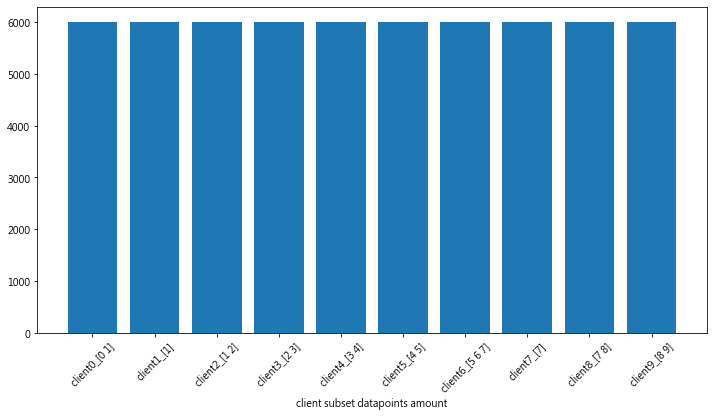

In [12]:
def bySample_bal_split(data, label, K):
    nums = len(label)//K
    lis = list(range(0,len(label),nums))

    subset = dict()

    for i in range(K-1):
        a, b = lis[i], lis[i+1]
        subset['client'+str(i)] = [data[a:b], label[a:b]]

    a = K-1
    subset['client'+str(a)] = [data[lis[a]:], label[lis[a]:]]
    return subset
K = 10
subset = bySample_bal_split(x_train_sorted, y_train_sorted, K)
view_clientDict(subset)

In [14]:
# import tensorflow as tf
class clint_k():
    
    def __init__(self, name):
        self.name = name
        
        self.attri = {'name':self.name}
    def set_content(self, data, label, model):
        content = {'name': self.name, 'data':data, 'label':label, 'model':model}
        self.data = data
        self.label = label
        self.model = model
        values_list = [self.name, self.data, self.label, self.model]
        keys_list = ['name','data', 'label', 'model']
        self.attri = dict(zip(keys_list, values_list))
        return content
    def show_content(self):

        return self.attri


In [15]:
def choice_client(hyper_para, choice, client_list):
    
    
    batch_size = hyper_para['B']
    epochs = hyper_para['E']
    
    for _ in choice:
        print('Training on client'+str(_))
        client = client_list['client'+str(_)]

        model = client.model

In [16]:
from tensorflow.keras.models import clone_model

def avg_weight(choice, Gmodel, client_list):
    tmp_model = clone_model(Gmodel)
    tmp_model.set_weights(Gmodel.get_weights())
    models = []
    weighting = []
    for _ in choice:
        models.append(client_list['client'+str(_)].model)
        weighting.append(len(client_list['client'+str(_)].data))
        
    weights = [model.get_weights() for model in models]
    new_weights = list()
    
    weighting = np.array(weighting)/np.sum(weighting)

    weights = [i for i in weights]
    
    for i in zip(*weights):
        a = np.average(i, weights=weighting, axis=0)
        new_weights.append(a)
    
    pt = 0
    for i in range(len(tmp_model.layers)):
        a = tmp_model.layers[i]

        if len(a.get_weights()) != 0:
            a.set_weights(new_weights[pt:len(a.get_weights())+pt])
            pt+=len(a.get_weights())
    del models, weighting, new_weights
    return tmp_model




In [17]:
def model_check(model_1, model_2):
    a = model_1.get_weights()
    for i in range(len(a)):
#         print(i)
        if np.array_equal(model_1.get_weights()[i], model_2.get_weights()[i]):
            print('layer %d is equal'%i)
            pass
        else:
#             print('Model not equal')
            print('layer %d is not equal'%i)

>>> 分割給 6 個client
>>> subset client0 資料維度
-- data shape (10000, 28, 28) --label shape (10000,)
>>> subset client5 資料維度
-- data shape (10000, 28, 28) --label shape (10000,)


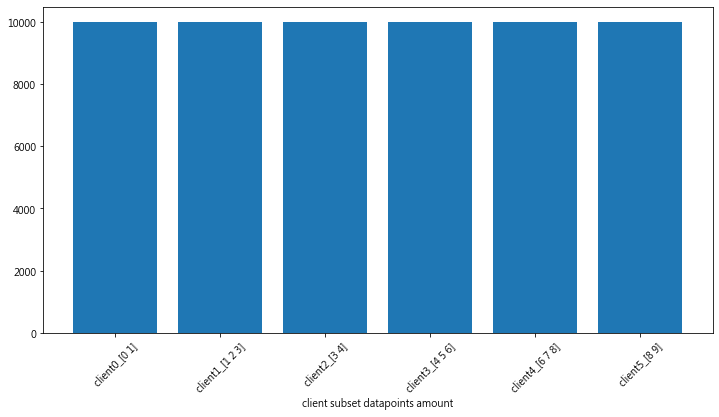

In [18]:
hyper_para = dict()
hyper_para['K'] = 6

subset= bySample_bal_split(x_train_sorted, y_train_sorted, hyper_para['K'])
view_clientDict(subset)


In [19]:
from tensorflow.keras.models import clone_model


Gmodel = simplecnn('server_model')


        
acc_model(X_test, y_test, Gmodel, 3000)

client_list = dict()

for _ in list(subset.keys()):

    client_list[_] = clint_k(_)
    client_list[_].set_content(data = subset[_][0], 
                               label = subset[_][1], model = clone_model(Gmodel))
    client_list[_].model.set_weights(Gmodel.get_weights())
print(client_list.keys())
client_list['client0'].show_content().keys()

# [i.trainable for i in Gmodel.layers]

dict_keys(['client0', 'client1', 'client2', 'client3', 'client4', 'client5'])


dict_keys(['name', 'data', 'label', 'model'])

## Setting para 

In [20]:
import numpy as np
# batchsize
hyper_para['B'] = 1024

# choice
# C = 1
hyper_para['C'] = 0.5

# int(np.ceil(C*hyper_para['K']))

# Epochs
hyper_para['E'] = 5

print(hyper_para)



{'K': 6, 'B': 1024, 'C': 0.5, 'E': 5}


In [21]:
for i in range(len(client_list)):
    client = client_list['client'+str(i)]
    model = client.model
    print(acc_model(X_test, y_test, model, 1000))

0.105
0.09
0.121
0.112
0.093
0.112


In [22]:
print(hyper_para)

{'K': 6, 'B': 1024, 'C': 0.5, 'E': 5}


![](https://i.imgur.com/8dItFYB.png)
<br>
![](https://i.imgur.com/rTr5a5R.png)
<br>
![](https://i.imgur.com/kdmGlG9.png)


In [23]:
import tensorflow as tf
def weight_norm(weight):
    norm = tf.norm([tf.norm(i) for i in weight])
    return norm

weight = Gmodel.get_weights()
weight_norm(weight)

<tf.Tensor: shape=(), dtype=float32, numpy=12.664275>

In [24]:
# weight = Gmodel.get_weights()

# for i in weight:
#     print(np.shape(i))
#     print(np.gradient(i))

In [25]:
def get_weights_to_model(new_weight, Gmodel):
    tmp_model = clone_model(Gmodel)
    
    pt = 0
    for i in range(len(tmp_model.layers)):
        a = tmp_model.layers[i]
        
        b = a.get_weights()
        if len(a.get_weights()) != 0:
            a.set_weights(new_weight[pt:len(a.get_weights())+pt])
            pt+=len(a.get_weights())
    return tmp_model

In [26]:
# from tensorflow.keras.models import clone_model
# import tensorflow as tf 
# def proximal_term(u, L_model, Gmodel):

#     golbal_weight = Gmodel.get_weights()
#     local_weight = L_model.get_weights()

#     weights = [golbal_weight, local_weight]
    
#     lis = []
#     for i in zip(*weights):

#         a = np.subtract(i[0], i[1])
#         b = tf.norm(a, ord=2)
#         lis.append(b)
#     weight_norm = tf.norm(lis)
# #     print(weight_norm)
#     prox_term = 0.5*u*(weight_norm**2)
# #         a = np.subtract()
# #         new_weights.append(a)
    
#     return prox_term
# # prox_term = proximal_term(1, Gmodel, Gmodel)
# weight = weight_subtract(Gmodel, Gmodel)
# weight_norm(weight)

In [27]:
def weight_subtract(L_model, Gmodel):
    golbal_weight = Gmodel.get_weights()
    local_weight = L_model.get_weights()
    
    weights = [golbal_weight, local_weight]
    
    new_weight = []
    for i in zip(*weights):

        sub_weight = tf.subtract(i[0], i[1])
        new_weight.append(sub_weight)
        
    return new_weight

# new_weight = weight_subtract(Gmodel, Gmodel)
# get_weights_to_model(new_weight, Gmodel)

![](https://i.imgur.com/NlJEXQm.png)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time

acc_test = []
acc_test.append(acc_model(X_test, y_test, Gmodel, 10000))

for rounds in range(500):
    clients = range(hyper_para['K'])
    size = int(np.ceil(hyper_para['C']*hyper_para['K']))
    choice = np.random.choice(clients, size = size, replace=False)

    batch_size = hyper_para['B']
    epochs = hyper_para['E']
    
    print('----------------------\nGmodel acc')
    print(acc_model(X_test, y_test, Gmodel, 1000))
    
    for _ in choice:
        print('*************************************')
        print('Training on client'+str(_))
        client = client_list['client'+str(_)]
    
        # Instantiate an optimizer to train the model.
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        # Instantiate a loss function.
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        # Prepare the metrics.
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
        print('*************************************')
        model = client.model
        
        weights_t = model.get_weights()
        
        X_train_, X_test_, y_train_, y_test_ = train_test_split(
                client.data, client.label, test_size=0.2, random_state=42)


        # Prepare the training dataset.
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train_, y_train_))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

        # Prepare the validation dataset.
        val_dataset = tf.data.Dataset.from_tensor_slices((X_test_, y_test_))
        val_dataset = val_dataset.batch(batch_size//10)

        
        #------------------------------------------
        start_time = time.time()
        
        epoch = 0
        local_train = True
        while local_train:
            epoch += 1
            if epoch > 8:
                local_train = False
                
            para_u = 1 # 0~1
            para_r = 1
            
#         for epoch in range(epochs):
            
            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                
                grad_global = []
                with tf.GradientTape() as tape:
                    
                    logits = Gmodel(x_batch_train, training=True)  # Logits for this minibatch
                    loss_value = loss_fn(y_batch_train, logits)
                    _ = tape.gradient(loss_value, Gmodel.trainable_weights)
                    grad_global.append(_)
                
                # Open a GradientTape to record the operations run
                # during the forward pass, which enables auto-differentiation.
                with tf.GradientTape() as tape:

                    # Run the forward pass of the layer.
                    # The operations that the layer applies
                    # to its inputs are going to be recorded
                    # on the GradientTape.
                    logits = model(x_batch_train, training=True)  # Logits for this minibatch

                    # Compute the loss value for this minibatch.
                    loss_value = loss_fn(y_batch_train, logits)
                
                    
                    a = weight_subtract(Gmodel, Gmodel)
                    prox_term = 0.5*para_u*weight_norm(weight)
                    
                    # Use the gradient tape to automatically retrieve
                    # the gradients of the trainable variables with respect to the loss.

                    grads = tape.gradient(loss_value + prox_term, model.trainable_weights)


                    # Run one step of gradient descent by updating
                    # the value of the variables to minimize the loss.
                    optimizer.apply_gradients(zip(grads, model.trainable_weights))
                    

                    similarity = weight_subtract(model, Gmodel)
                    print('aaa', step)
#                     print(weight_norm(similarity))

                    nabla_hk = []
                    for i in range(len(grads)):
                        a = tf.add(grads[i], para_u*similarity[i])
                        nabla_hk.append(a)


                    F_global = grad_global[0]
                    print('this',para_r*weight_norm(F_global))

                    if weight_norm(nabla_hk) <= para_r*weight_norm(F_global):
                        pass
                        print('aaa')
                        print(weight_norm(grads))
                        print(para_r*weight_norm(F_global))
                    else:
                        local_train = False
                        print('bbb')
                        print(weight_norm(grads))
                        print(para_r*weight_norm(F_global))
                        
    
#             print('epoch',epoch, 'on ', client.name)
                        
                    
                    
                   
        print("Time taken: %.2fs" % (time.time() - start_time))
                # Log every 200 batches.
#                 if step % 10 == 0:
#                     print(
#                         "Training loss (for one batch) at step %d: %.4f"
#                         % (step, float(loss_value))
#                     )
#                     print("Seen so far: %s samples" % ((step + 1) * batch_size))
#             print(acc_model(X_test_, y_test_, model, 1000))

        #----------------------------------
        
        
    Gmodel = avg_weight(choice, Gmodel, client_list)
    for i in client_list:
        client_list[i].model.set_weights(Gmodel.get_weights()) 

    
    print('----------------------\nGmodel acc')
    print(acc_model(X_test, y_test, Gmodel, 1000))
    acc_test.append(acc_model(X_test, y_test, Gmodel, 10000))

----------------------
Gmodel acc
0.125
*************************************
Training on client4
*************************************
aaa 0
this tf.Tensor(0.15858988, shape=(), dtype=float32)
bbb
tf.Tensor(0.15858988, shape=(), dtype=float32)
tf.Tensor(0.15858988, shape=(), dtype=float32)
aaa 1
this tf.Tensor(0.15959387, shape=(), dtype=float32)
bbb
tf.Tensor(0.23964854, shape=(), dtype=float32)
tf.Tensor(0.15959387, shape=(), dtype=float32)
aaa 2
this tf.Tensor(0.1554988, shape=(), dtype=float32)
bbb
tf.Tensor(0.41339973, shape=(), dtype=float32)
tf.Tensor(0.1554988, shape=(), dtype=float32)
aaa 3
this tf.Tensor(0.16961499, shape=(), dtype=float32)
bbb
tf.Tensor(0.8120416, shape=(), dtype=float32)
tf.Tensor(0.16961499, shape=(), dtype=float32)
aaa 4
this tf.Tensor(0.16513747, shape=(), dtype=float32)
bbb
tf.Tensor(1.2247362, shape=(), dtype=float32)
tf.Tensor(0.16513747, shape=(), dtype=float32)
aaa 5
this tf.Tensor(0.15990545, shape=(), dtype=float32)
bbb
tf.Tensor(1.3992643, shape

In [ ]:
for i in range(len(client_list)):
    client = client_list['client'+str(i)]
    model = client.model
    print(acc_model(X_test, y_test, Gmodel, 1000))

In [ ]:
import pandas as pd
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
df = pd.DataFrame(acc_test, columns=['Gmodel acc'])

df['hyper_keys'] = pd.DataFrame(hyper_para.keys())
df['hyper_item'] = pd.DataFrame(hyper_para.values())
df.to_csv('./data/acc_test_'+timestr+'.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


directory = './data'
def plt_acctest(path = max([os.path.join(directory,d) for d in os.listdir(directory)], key=os.path.getmtime) ):
    plt.figure(figsize=(36,8))
    df = pd.read_csv(path)
    print(df.loc[:3, ['hyper_keys', 'hyper_item']])
    plt.plot(list(df.index), df['Gmodel acc'])
    ax = [0, list(df.index)[-1]]
    a = np.max(df['Gmodel acc'].values)
    ay = [a,a]
    plt.plot(ax, ay)
    plt.text( 0, a-0.1, 'max = '+str(a), horizontalalignment='center',
          verticalalignment='center', fontsize = 24)
        
    w = 10
    mavg = moving_average(df['Gmodel acc'], w)
#     return np.convolve(x, np.ones(w), 'valid') / w
    plt.plot(list(df.index)[:-(w-1)], mavg)
    
    a = np.ceil(0.6*len(df))
    plt.text( a,0.1, 'round = '+str(len(df)-1), horizontalalignment='center',
          verticalalignment='center', fontsize = 30)
    plt.xticks(list(df.index))
    plt.show()
    
plt_acctest()